In [1]:
import numpy as np

from stochastic_volatility_models.src.core.underlying import Underlying
from stochastic_volatility_models.src.core.volatility_surface import VolatilitySurface
from stochastic_volatility_models.src.core.pricing_models import PricingModel
from stochastic_volatility_models.src.models.heston import HestonModel

2024-08-01 01:00:48.856 | INFO     | stochastic_volatility_models.config:initialise:30 - Loaded module `stochastic_volatility_models` from project directory path `/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules`


```python
p1 = {
	'initial_variance': 1.5735434638117027,
	'long_term_variance': -5.585043916635598,
	'volatility_of_volatility': -1.4008118465141628,
	'mean_reversion_rate': 2.7847101214701397,
	'wiener_correlation': -0.8231322657874336
}
```

In [2]:
ticker = "SPX"
spx = Underlying(ticker)
vix = Underlying("VIX")
pricing_model = PricingModel()
time = np.datetime64("2022-03-03")

In [3]:
expiries = np.array(
	["2022-03-04", "2022-03-09", "2022-03-11", "2022-03-18", "2022-03-23", "2022-03-25", "2022-03-30", "2022-03-31", "2022-04-01", "2022-04-08", "2022-04-14", "2022-04-22", "2022-04-29", "2022-05-20", "2022-05-31", "2022-06-17", "2022-06-30", "2022-07-15", "2022-07-29", "2022-08-31"], dtype=np.datetime64
)

strikes = np.array(
	[
		2200,
		2400,
		2600,
		2800,
		3000,
		3200,
		3400,
		3500,
		3600,
		3700,
		3800,
		3850,
		3900,
		3950,
		3975,
		4000,
		4025,
		4040,
		4050,
		4060,
		4070,
		4075,
		4080,
		4090,
		4100,
		4110,
		4120,
		4125,
		4130,
		4140,
		4150,
		4160,
		4170,
		4175,
		4180,
		4190,
		4200,
		4210,
		4220,
		4225,
		4230,
		4240,
		4250,
		4260,
		4270,
		4275,
		4280,
		4290,
		4300,
		4310,
		4320,
		4325,
		4330,
		4340,
		4350,
		4360,
		4370,
		4375,
		4380,
		4390,
		4400,
		4410,
		4420,
		4425,
		4430,
		4440,
		4450,
		4460,
		4470,
		4475,
		4480,
		4490,
		4500,
		4510,
		4525,
		4550,
		4600,
		4650,
		4700,
		4800,
		5000,
		5200,
		5400,
	]
)
spx_vs = VolatilitySurface(
	underlying=spx,
	expiries=expiries,
	strikes=strikes,
	monthly=False,
)

In [4]:
expiries = np.array(["2022-03-09", "2022-03-23", "2022-03-30", "2022-04-06"], dtype=np.datetime64)

strikes = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
vix_vs = VolatilitySurface(
	underlying=vix,
	expiries=expiries,
	strikes=strikes,
	monthly=False,
)

In [5]:
model = HestonModel(
	parameters={
		"initial_variance": 0.16,
		"long_term_variance": 0.25,
		"volatility_of_volatility": 0.8,
		"mean_reversion_rate": 6.2,
		"wiener_correlation": 0.5,
	}
)

In [6]:
# from typing import Callable
# import numpy as np
# from numpy.typing import NDArray
# from numba import jit, njit
# import numba as nb
# from scipy.integrate import quad


# DEFAULT_LG_DEGREE = 64

# # @njit(cache=True)
# def characteristic_function(
# 	u: complex | NDArray[np.complex64],
# 	spot: float,
# 	time_to_expiry: float,
# 	risk_free_rate: float,
# 	dividend_yield: float,
# 	initial_variance: float,
# 	long_term_variance: float,
# 	volatility_of_volatility: float,
# 	mean_reversion_rate: float,
# 	wiener_correlation: float,
# ) -> complex | NDArray[np.complex64]:
# 	F = spot * np.exp((risk_free_rate - dividend_yield) * time_to_expiry)
# 	xi = mean_reversion_rate - volatility_of_volatility * wiener_correlation * 1j * u
# 	d = np.sqrt(xi**2 + (u**2 + 1j * u) * volatility_of_volatility**2)
# 	A1 = (u**2 + u * 1j) * np.sinh(d * time_to_expiry / 2)
# 	A2 = (d * np.cosh(d * time_to_expiry / 2) + xi * np.sinh(d * time_to_expiry / 2)) / initial_variance
# 	A = A1 / A2
# 	D = np.log(d / initial_variance) + (mean_reversion_rate - d) * time_to_expiry / 2 - np.log(((d + xi) + (d - xi) * np.exp(-d * time_to_expiry)) / (2 * initial_variance))
# 	value = np.exp(1j * u * np.log(F / spot) - (mean_reversion_rate * long_term_variance * wiener_correlation * time_to_expiry * 1j * u) / volatility_of_volatility - A + (2 * mean_reversion_rate * long_term_variance * D) / (volatility_of_volatility**2))

# 	return value


# def lg_integrate(
# 	integrand: Callable[[NDArray[np.float64]], NDArray[np.float64]],
# 	degree: int = DEFAULT_LG_DEGREE,
# ) -> float:
# 	def transformed_integrand(x):
# 		return 2 * integrand((1 + x) / (1 - x)) / ((1 - x) ** 2)

# 	nodes, weights = np.polynomial.legendre.leggauss(deg=degree)
# 	approximation = np.sum(weights * transformed_integrand(nodes))

# 	return approximation

# def integrate(
# 	integrand: Callable[[NDArray[np.float64]], NDArray[np.float64]],
# 	degree: int = DEFAULT_LG_DEGREE,
# ) -> float:
# 	return quad(integrand, 0, np.inf)[0]


# def p1_value(
# 	spot: float,
# 	strike: int,
# 	time_to_expiry: float,
# 	risk_free_rate: float,
# 	dividend_yield: float,
# 	initial_variance: float,
# 	long_term_variance: float,
# 	volatility_of_volatility: float,
# 	mean_reversion_rate: float,
# 	wiener_correlation: float,
# 	degree: int = DEFAULT_LG_DEGREE,
# ) -> float:
# 	# @njit
# 	def integrand(
# 		u: NDArray[np.float64],
# 	) -> NDArray[np.float64]:
# 		return np.real(
# 			(np.exp(-1j * u * np.log(strike / spot)) / (u * 1j))
# 			* (
# 				characteristic_function(
# 					u=u - 1j,
# 					spot=spot,
# 					time_to_expiry=time_to_expiry,
# 					risk_free_rate=risk_free_rate,
# 					dividend_yield=dividend_yield,
# 					initial_variance=initial_variance,
# 					long_term_variance=long_term_variance,
# 					volatility_of_volatility=volatility_of_volatility,
# 					mean_reversion_rate=mean_reversion_rate,
# 					wiener_correlation=wiener_correlation,
# 				)
# 				/ characteristic_function(
# 					u=-1j,
# 					spot=spot,
# 					time_to_expiry=time_to_expiry,
# 					risk_free_rate=risk_free_rate,
# 					dividend_yield=dividend_yield,
# 					initial_variance=initial_variance,
# 					long_term_variance=long_term_variance,
# 					volatility_of_volatility=volatility_of_volatility,
# 					mean_reversion_rate=mean_reversion_rate,
# 					wiener_correlation=wiener_correlation,
# 				)
# 			)
# 		)

# 	integral = lg_integrate(
# 		integrand=integrand,
# 		degree=degree,
# 	)

# 	value = integral / np.pi + 1 / 2

# 	return value


# def p2_value(
# 	spot: float,
# 	strike: int,
# 	time_to_expiry: float,
# 	risk_free_rate: float,
# 	dividend_yield: float,
# 	initial_variance: float,
# 	long_term_variance: float,
# 	volatility_of_volatility: float,
# 	mean_reversion_rate: float,
# 	wiener_correlation: float,
# 	degree: int = DEFAULT_LG_DEGREE,
# ) -> float:
# 	# @njit
# 	def integrand(
# 		u: NDArray[np.float64],
# 	) -> NDArray[np.float64]:
# 		return np.real(
# 			(np.exp(-1j * u * np.log(strike / spot)) / (u * 1j))
# 			* characteristic_function(
# 				u=u,  # type: ignore
# 				spot=spot,
# 				time_to_expiry=time_to_expiry,
# 				risk_free_rate=risk_free_rate,
# 				dividend_yield=dividend_yield,
# 				initial_variance=initial_variance,
# 				long_term_variance=long_term_variance,
# 				volatility_of_volatility=volatility_of_volatility,
# 				mean_reversion_rate=mean_reversion_rate,
# 				wiener_correlation=wiener_correlation,
# 			)
# 		)

# 	integral = lg_integrate(
# 		integrand=integrand,
# 		degree=degree,
# 	)

# 	value = integral / np.pi + 1 / 2

# 	return value


# # @jit(parallel=True)
# def price_heston(
# 	spot: float,
# 	types: NDArray[str],  # type: ignore
# 	strikes: NDArray[np.int64],
# 	time_to_expiries: NDArray[np.float64],
# 	risk_free_rates: NDArray[np.float64],
# 	dividend_yields: NDArray[np.float64],
# 	initial_variance: float,
# 	long_term_variance: float,
# 	volatility_of_volatility: float,
# 	mean_reversion_rate: float,
# 	wiener_correlation: float,
# ) -> NDArray[np.float64]:
# 	p1 = np.empty(shape=strikes.shape, dtype=np.float64)
# 	p2 = np.empty(shape=strikes.shape, dtype=np.float64)
# 	for i in nb.prange(len(strikes)):
# 		print(f"{i+1}/{len(strikes)}")
# 		p1[i] = p1_value(
# 			spot=spot,
# 			strike=strikes[i],
# 			time_to_expiry=time_to_expiries[i],
# 			risk_free_rate=risk_free_rates[i],
# 			dividend_yield=dividend_yields[i],
# 			initial_variance=initial_variance,
# 			long_term_variance=long_term_variance,
# 			volatility_of_volatility=volatility_of_volatility,
# 			mean_reversion_rate=mean_reversion_rate,
# 			wiener_correlation=wiener_correlation,
# 		)
# 		p2[i] = p2_value(
# 			spot=spot,
# 			strike=strikes[i],
# 			time_to_expiry=time_to_expiries[i],
# 			risk_free_rate=risk_free_rates[i],
# 			dividend_yield=dividend_yields[i],
# 			initial_variance=initial_variance,
# 			long_term_variance=long_term_variance,
# 			volatility_of_volatility=volatility_of_volatility,
# 			mean_reversion_rate=mean_reversion_rate,
# 			wiener_correlation=wiener_correlation,
# 		)

# 	price = spot * np.exp(-dividend_yields * time_to_expiries) * (p1 - (types == "P").astype(int)) - strikes * np.exp(-risk_free_rates * time_to_expiries) * (p2 - (types == "P").astype(int))

# 	return price


In [7]:
# import numpy as np
# from scipy.integrate import quad

# integrand = lambda u: np.exp(-u)
# def transformed_integrand(x):
# 	u = lambda x: (1+x) / (1-x)
# 	return 2 * integrand(u(x)) / ((1-x) ** 2)

# degree=40
# nodes, weights = np.polynomial.legendre.leggauss(deg=degree)
# # nodes = 0.5 * (nodes + 1)
# # weights = 0.5 * weights
# # approximation = sum(weights * transformed_integrand(nodes))
# approximation = np.sum(weights * transformed_integrand(nodes))
# print(approximation)
# print(quad(integrand, 0, np.inf))


In [8]:
# # spot = 100
# # strikes = np.array([100, 100])
# # types = np.array(["C", "P"])
# # time_to_expiries = np.array([1.,1.])
# # risk_free_rates = np.array([0.05,0.05])
# # dividend_yields = np.array([0,0])
# spot = 1
# strikes = np.array([1.0766, 1.0766]) #0.119047619047619
# types = np.array(["C", "P"])
# time_to_expiries = np.array([1.42857142857143,1.42857142857143]) #0.9371
# risk_free_rates = np.array([0.02,0.02])
# dividend_yields = np.array([0,0])
# parameters = {
# 	"mean_reversion_rate": 3.,
# 	"initial_variance": 0.08,
# 	"long_term_variance": 0.1,
# 	"volatility_of_volatility": 0.25,
# 	"wiener_correlation": -0.8,
# }

# p1 = np.empty(shape=strikes.shape, dtype=np.float64)
# p2 = np.empty(shape=strikes.shape, dtype=np.float64)
# for i in nb.prange(len(strikes)):
# 	p1[i] = p1_value(
# 		spot=spot,
# 		strike=strikes[i],
# 		time_to_expiry=time_to_expiries[i],
# 		risk_free_rate=risk_free_rates[i],
# 		dividend_yield=dividend_yields[i],
# 		**parameters,
# 	)
# 	p2[i] = p2_value(
# 		spot=spot,
# 		strike=strikes[i],
# 		time_to_expiry=time_to_expiries[i],
# 		risk_free_rate=risk_free_rates[i],
# 		dividend_yield=dividend_yields[i],
# 		**parameters,
# 	)

# price = spot * np.exp(-dividend_yields * time_to_expiries) * (p1 - (types == "P").astype(int)) - strikes * np.exp(-risk_free_rates * time_to_expiries) * (p2 - (types == "P").astype(int))
# price


In [9]:
# from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility
# from py_vollib_vectorized.models import vectorized_black_scholes_merton

# # [implied_volatility(p, spot, strike, time_to_expirie, risk_free_rate, dividend_yield, type_) for p, strike, time_to_expirie, risk_free_rate, dividend_yield, type_ in zip(price,strikes, time_to_expiries,risk_free_rates, dividend_yields, types)]
# display(vectorized_implied_volatility(price, spot,strikes, time_to_expiries,risk_free_rates, np.array([type_.lower() for type_ in types]), dividend_yields))
# display(vectorized_black_scholes_merton(np.array([type_.lower() for type_ in types]), spot,strikes, time_to_expiries,risk_free_rates, 0.2975, dividend_yields, ))
# display(vectorized_black_scholes_merton(np.array([type_.lower() for type_ in types]), spot,strikes, time_to_expiries,risk_free_rates, 0.3007, dividend_yields, ))
# display(vectorized_black_scholes_merton(np.array([type_.lower() for type_ in types]), spot,strikes, time_to_expiries,risk_free_rates, 0.2808, dividend_yields, ))


In [10]:
spx_vs.model_price(time=time, model=model)

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning: overflow encountered in sinh
  A1 = (u**2 + u * 1j) * np.sinh(d * time_to_expiry / 2)
/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  A1 = (u**2 + u * 1j) * np.sinh(d * time_to_expiry / 2)
/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:45: RuntimeWarning: overflow encountered in cosh
  A2 = (d * np.cosh(d * time_to_expiry / 2) + xi * np.sinh(d * time_to_expiry / 2)) / i

,Mid
SPXW 220304C2200000,2.157675e+03
SPXW 220304P2200000,7.024916e-11
SPXW 220309C2200000,2.156645e+03
SPXW 220309P2200000,-7.624328e-08
SPXW 220311C2200000,2.155941e+03
...,...
SPXW 220715P5400000,NaN
SPXW 220729C5400000,NaN
SPXW 220729P5400000,NaN
SPXW 220831C5400000,NaN


In [11]:
from stochastic_volatility_models.visualisations.volatility_surface import plot_volatility_surface

fig = plot_volatility_surface(
	time=time,
	volatility_surface=spx_vs,
	quantity_method="model_price",
	model=model,
	plot_parameters={"moneyness": False, "time_to_expiry": False, "log_moneyness": False, "mid_price": True},
)
fig.show()


fig = plot_volatility_surface(
	time=time,
	volatility_surface=spx_vs,
	quantity_method="model_pricing_implied_volatility",
	pricing_model=PricingModel(),
	model=model,
	plot_parameters={"moneyness": False, "time_to_expiry": False, "log_moneyness": False, "mid_price": True},
)
fig.show()

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning: overflow encountered in sinh
  A1 = (u**2 + u * 1j) * np.sinh(d * time_to_expiry / 2)
/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  A1 = (u**2 + u * 1j) * np.sinh(d * time_to_expiry / 2)
/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:45: RuntimeWarning: overflow encountered in cosh
  A2 = (d * np.cosh(d * time_to_expiry / 2) + xi * np.sinh(d * time_to_expiry / 2)) / i

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning:

overflow encountered in sinh

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:45: RuntimeWarning:

overflow encountered in cosh

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning:

overflow encountered in sinh

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:45: RuntimeWarning:

overflow encountered in cosh

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/

T: 2022-03-04


/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [2, 3, 6, 7, 42, 43, 44, 45, 46, 47, 84, 85, 162, 163, 280, 281, 3240, 3241, 3280, 3281]



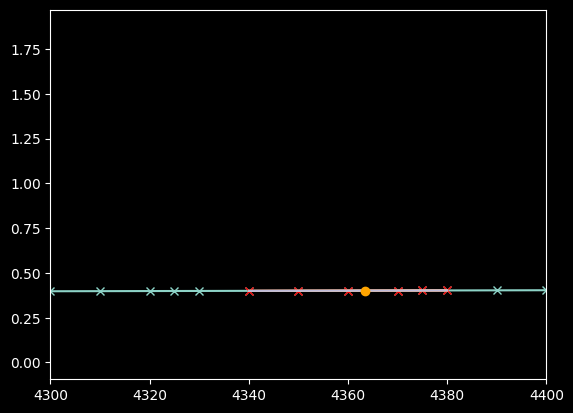

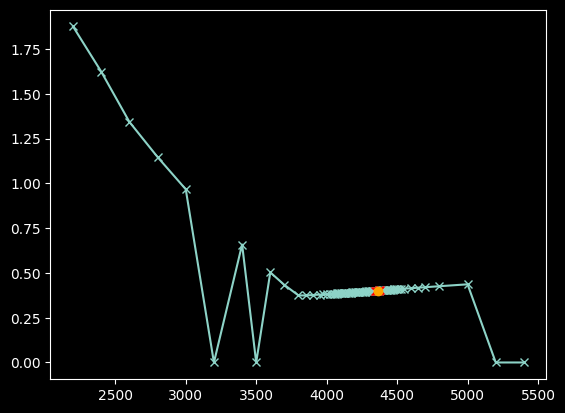

T: 2022-03-09


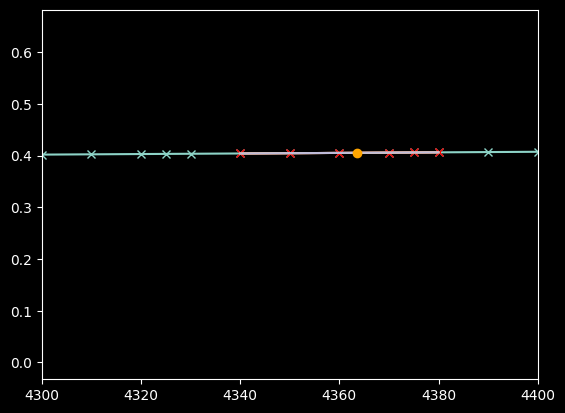

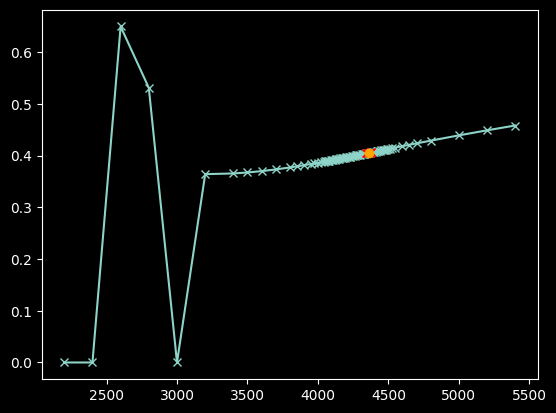

T: 2022-03-11


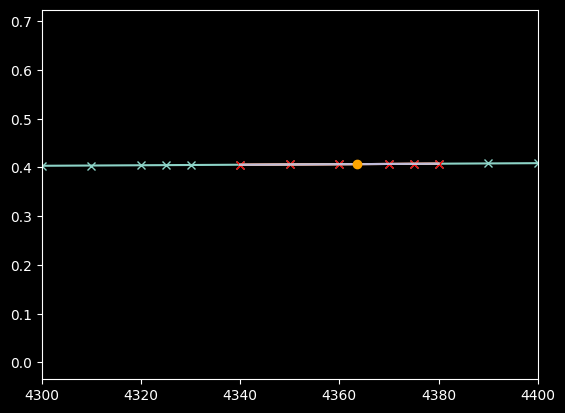

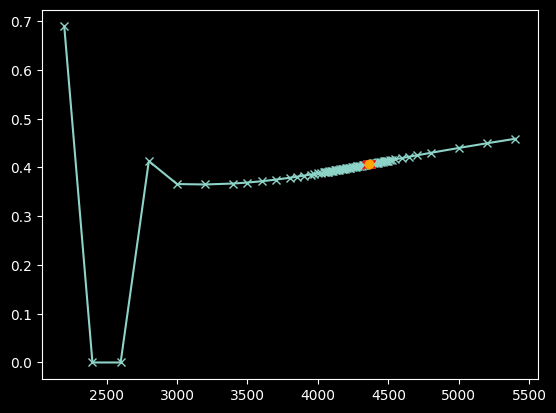

T: 2022-03-18


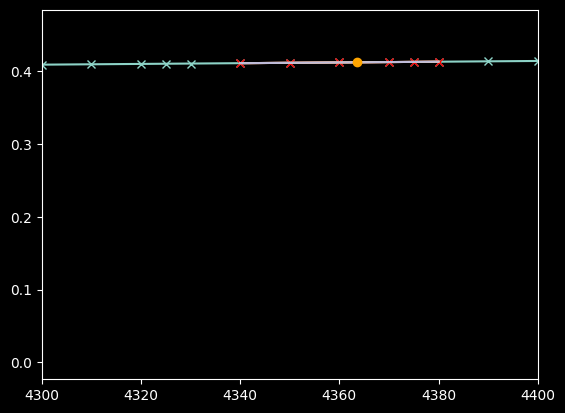

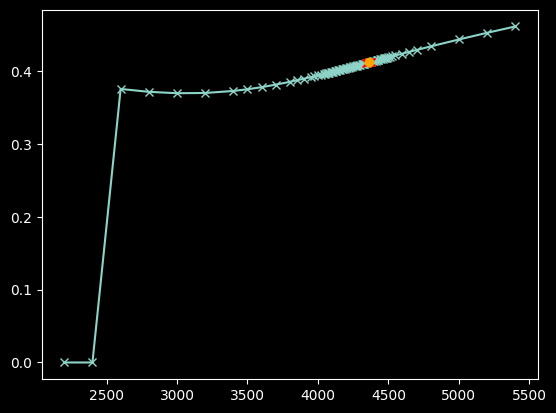

T: 2022-03-23


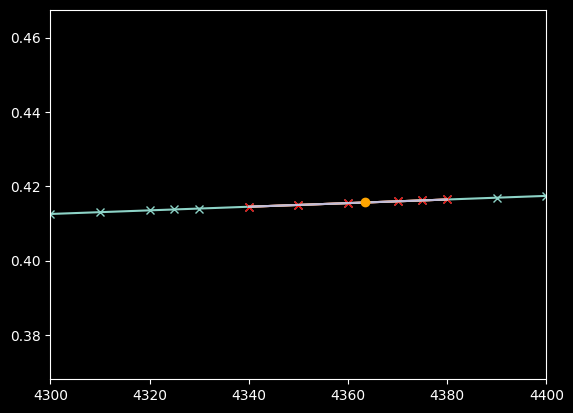

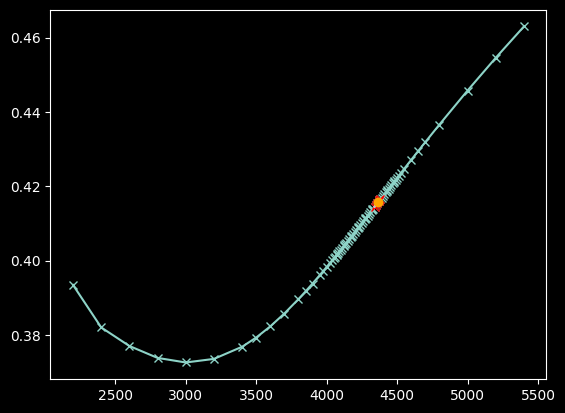

T: 2022-03-25


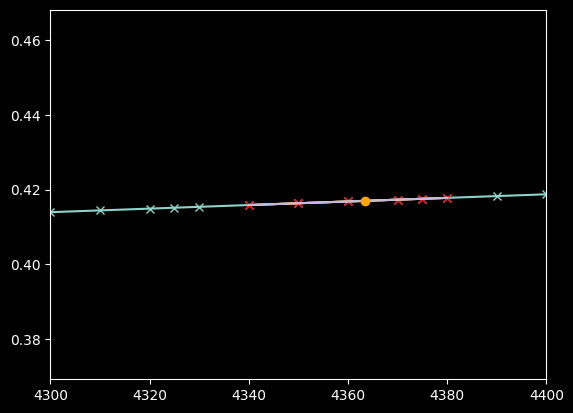

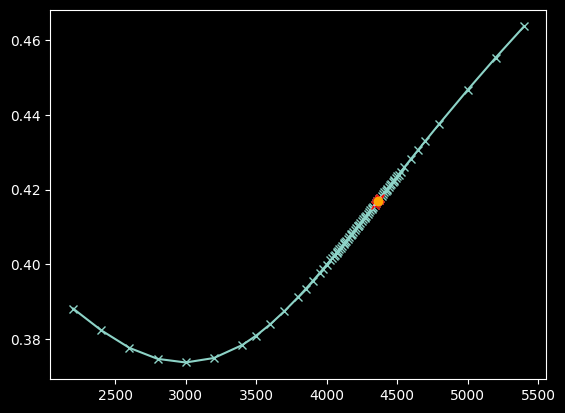

T: 2022-03-30


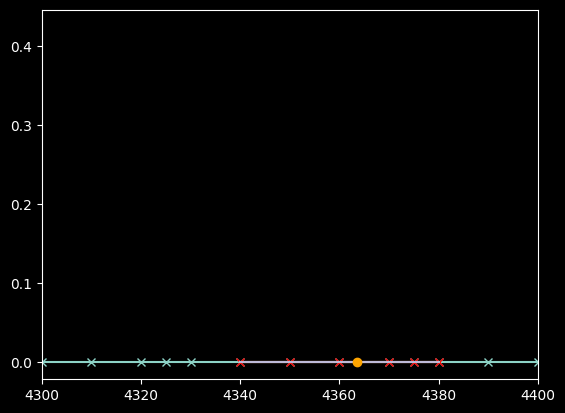

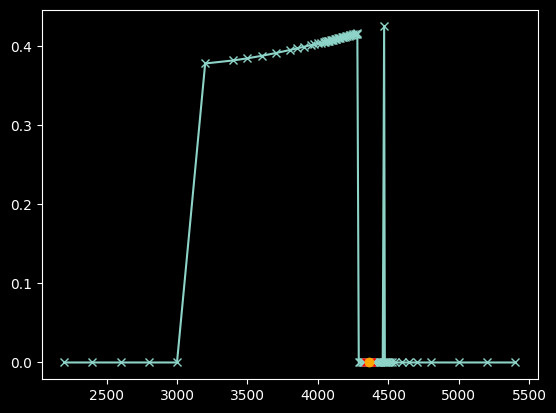

T: 2022-03-31


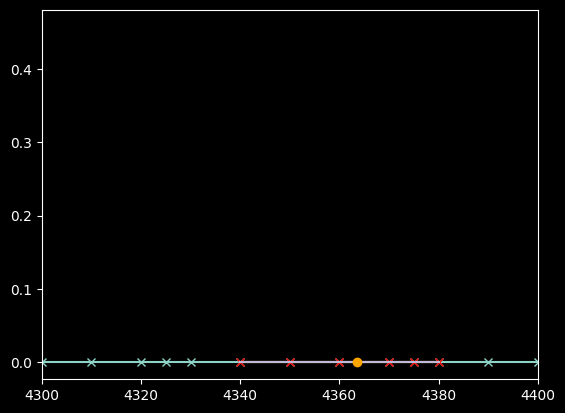

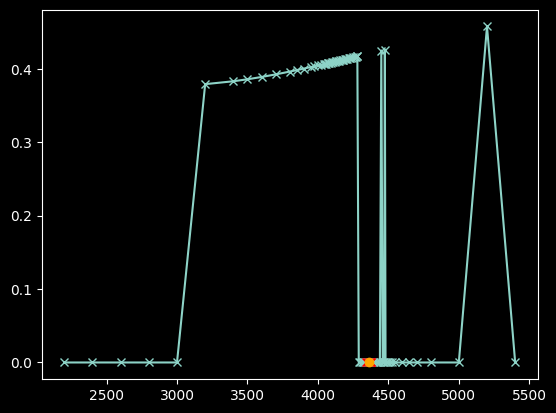

T: 2022-04-01


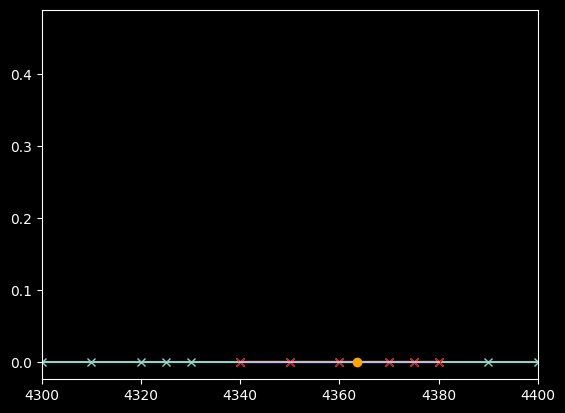

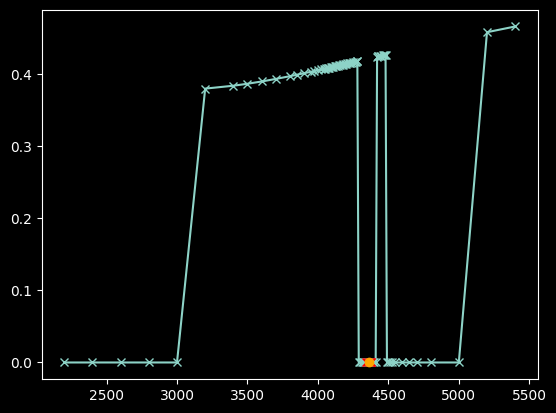

T: 2022-04-08


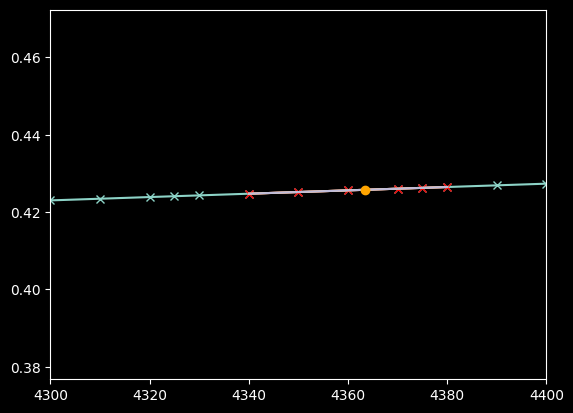

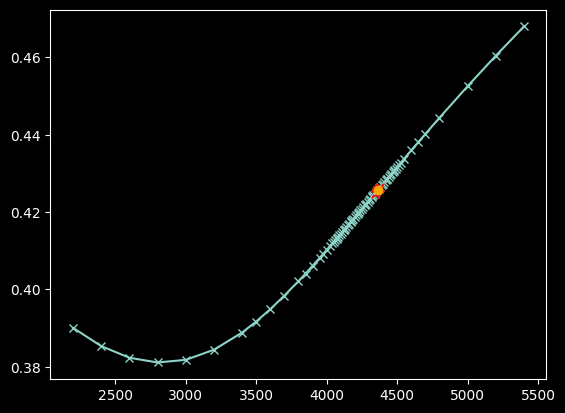

T: 2022-04-14


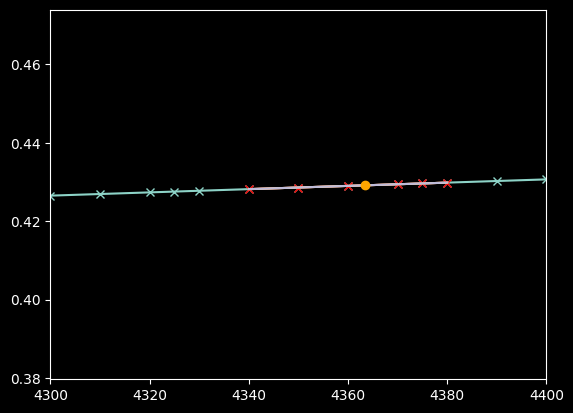

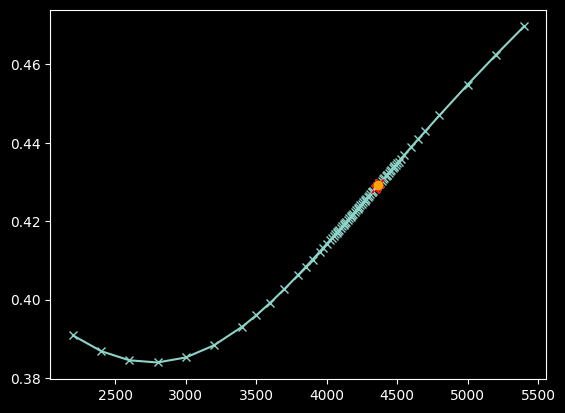

T: 2022-04-22


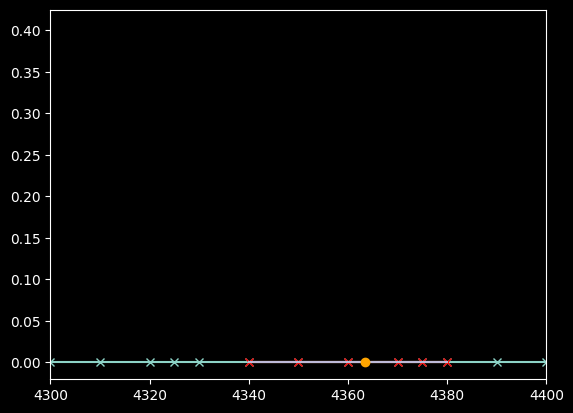

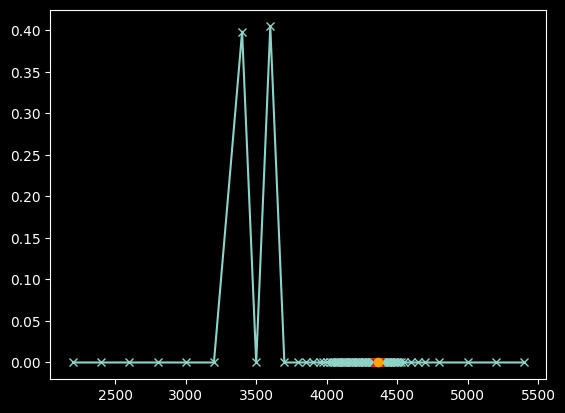

T: 2022-04-29


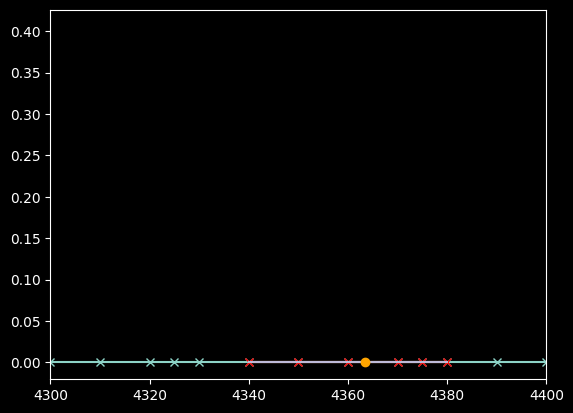

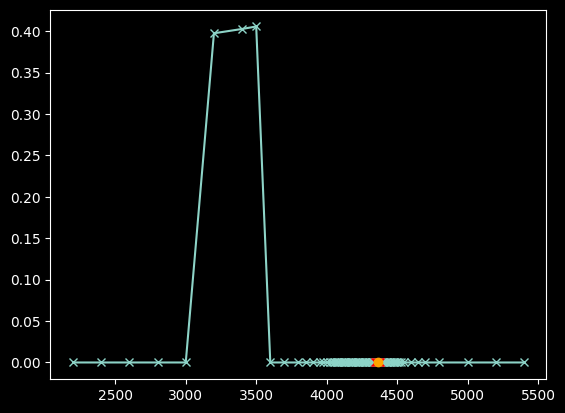

T: 2022-05-20


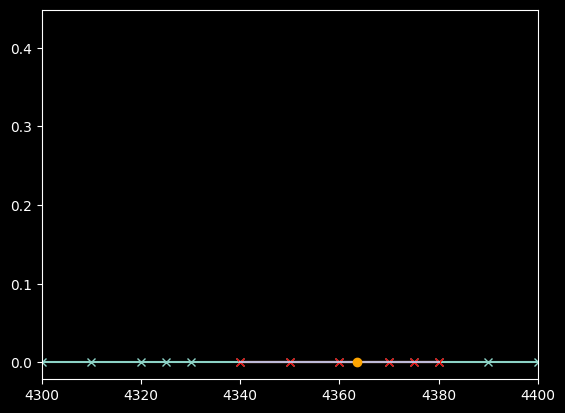

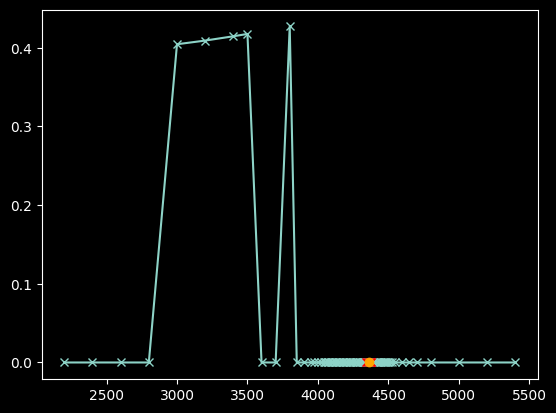

T: 2022-05-31


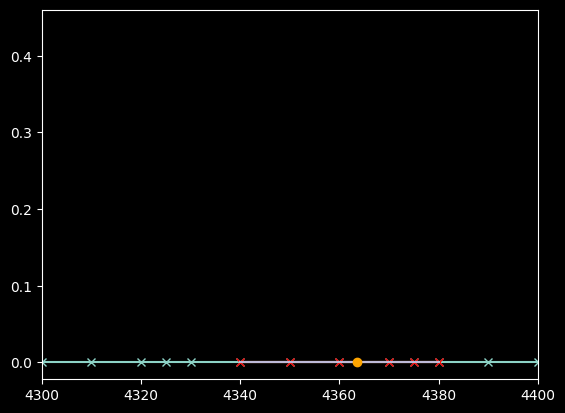

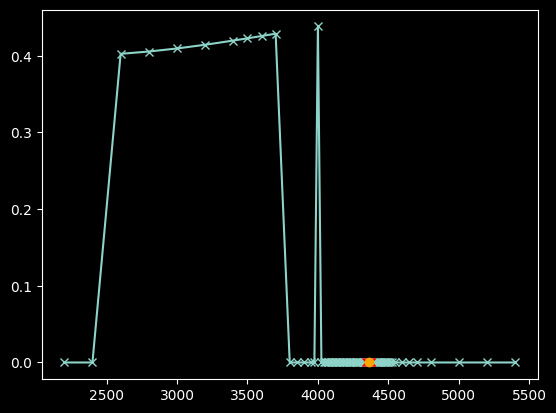

T: 2022-06-17


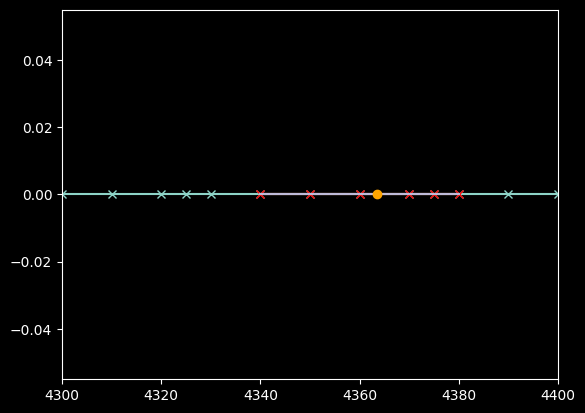

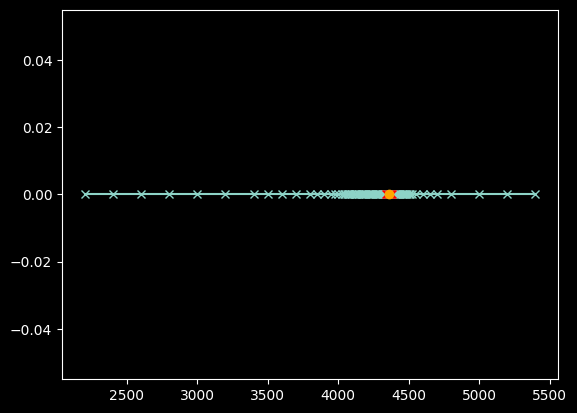

T: 2022-06-30


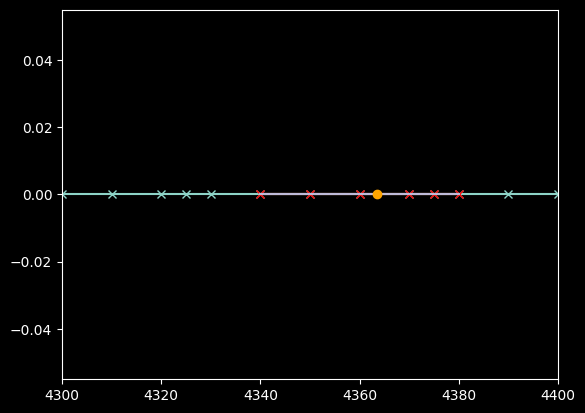

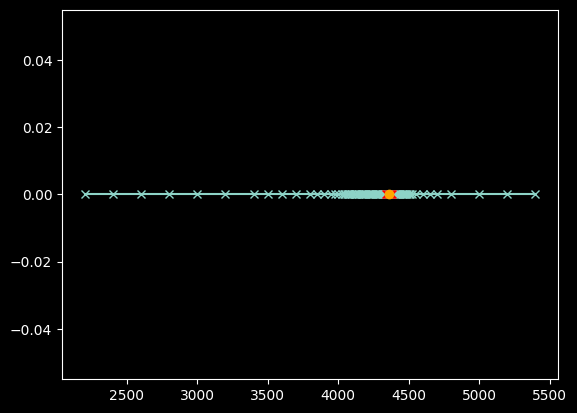

T: 2022-07-15


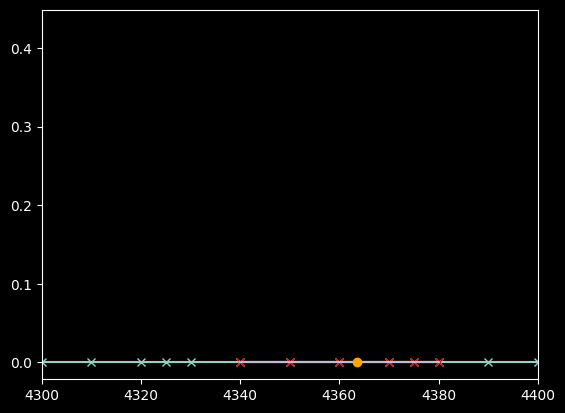

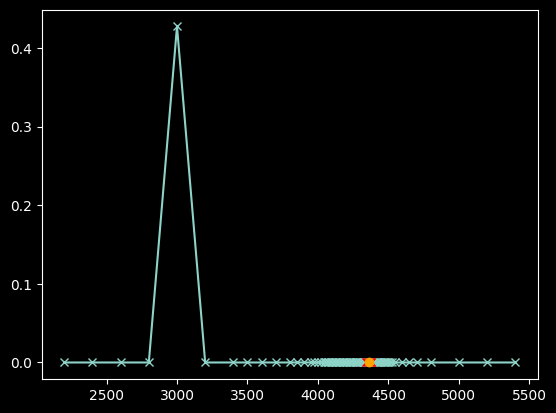

T: 2022-07-29


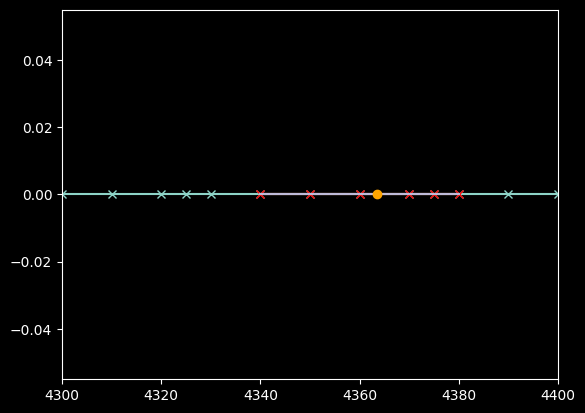

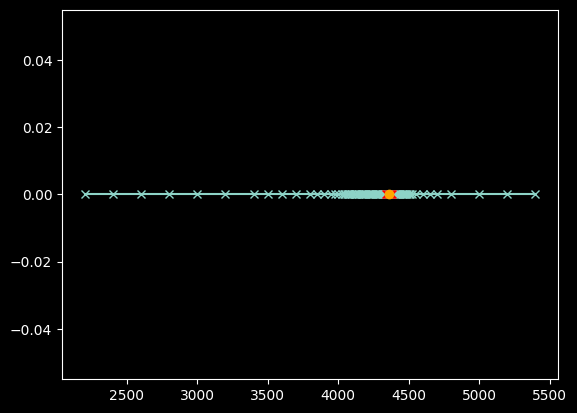

T: 2022-08-31


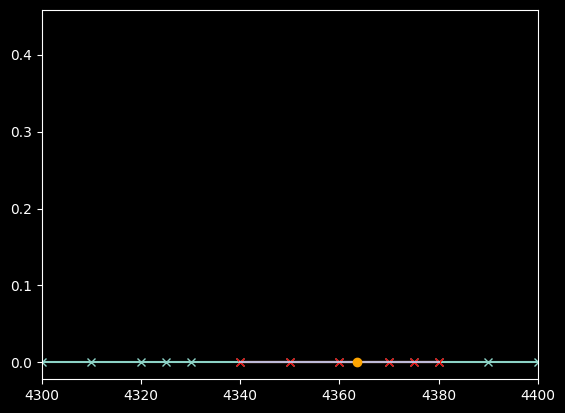

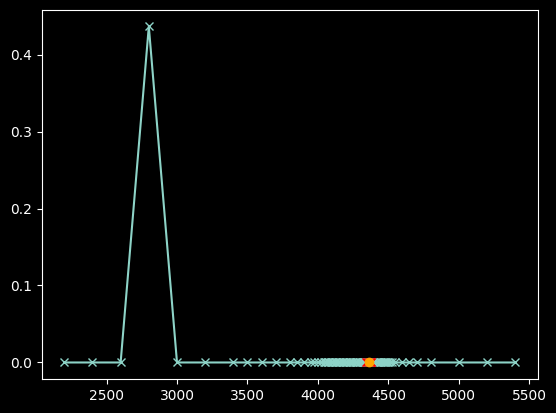

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from pandas import DataFrame
from typing import cast

from stochastic_volatility_models.src.core.underlying import Underlying
from stochastic_volatility_models.src.core.volatility_surface import VolatilitySurface
from stochastic_volatility_models.src.core.pricing_models import PricingModel
from stochastic_volatility_models.src.utils.options.strikes import find_closest_strikes
from stochastic_volatility_models.src.utils.options.expiry import time_to_expiry
from stochastic_volatility_models.visualisations.volatility_surface import plot_volatility_surface


volatility_surface = spx_vs
surface = volatility_surface.surface_quantities(
	time=time,
	quantity_method="model_pricing_implied_volatility",
	price_types=["Mid"],
	out_the_money=True,
	pricing_model=PricingModel(),
	model=model,
)[0]
for i, expiry in enumerate(volatility_surface.expiries):
	print(f"T: {expiry}")
	t2x = time_to_expiry(time, volatility_surface.expiries)
	indices = find_closest_strikes(
		strikes=volatility_surface.strikes,
		spot=volatility_surface.underlying.price(time=time),
	)
	# print(indices)
	cs = CubicSpline(
		x=indices,
		y=cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values,
		bc_type="natural",
	)
	x = np.linspace(indices.min(), indices.max(), 100)
	s, i = np.polyfit(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].to_numpy(), 1)

	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.plot(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values, linestyle=None, marker="x", color="red")
	plt.plot(x, s * x + i)
	plt.plot(x, cs(x))
	plt.plot((spot := volatility_surface.underlying.price(time=time)), cs(spot), color="orange", marker="o")
	plt.gca().set_xlim(4300, 4400)
	# plt.gca().set_ylim(0.22, 0.34)
	plt.show()

	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.plot(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values, linestyle=None, marker="x", color="red")
	plt.plot(x, s * x + i)
	plt.plot(x, cs(x))
	plt.plot((spot := volatility_surface.underlying.price(time=time)), cs(spot), color="orange", marker="o")
	plt.show()

In [23]:
np.polynomial.legendre.leggauss(deg=64)[0]

array([-0.99930504, -0.99634012, -0.99101337, -0.98333625, -0.97332683,
       -0.9610088 , -0.94641137, -0.92956917, -0.91052214, -0.88931545,
       -0.8659994 , -0.8406293 , -0.81326532, -0.78397236, -0.75281991,
       -0.71988185, -0.68523631, -0.64896547, -0.61115536, -0.57189565,
       -0.53127946, -0.48940315, -0.44636602, -0.40227016, -0.35722016,
       -0.31132287, -0.26468716, -0.21742364, -0.16964442, -0.12146282,
       -0.07299312, -0.02435029,  0.02435029,  0.07299312,  0.12146282,
        0.16964442,  0.21742364,  0.26468716,  0.31132287,  0.35722016,
        0.40227016,  0.44636602,  0.48940315,  0.53127946,  0.57189565,
        0.61115536,  0.64896547,  0.68523631,  0.71988185,  0.75281991,
        0.78397236,  0.81326532,  0.8406293 ,  0.8659994 ,  0.88931545,
        0.91052214,  0.92956917,  0.94641137,  0.9610088 ,  0.97332683,
        0.98333625,  0.99101337,  0.99634012,  0.99930504])

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning:

overflow encountered in sinh

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:44: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/models/heston.py:45: RuntimeWarning:

overflow encountered in cosh

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules/stochastic_volatility_models/stochastic_volatility_models/src/

T: 2022-03-04


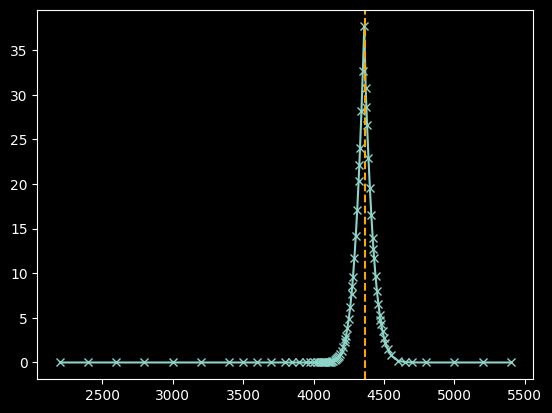

T: 2022-03-09


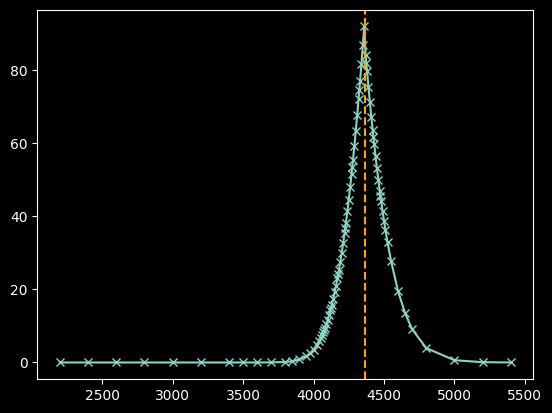

T: 2022-03-11


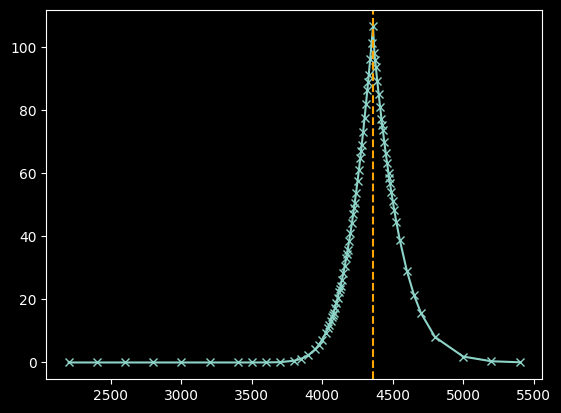

T: 2022-03-18


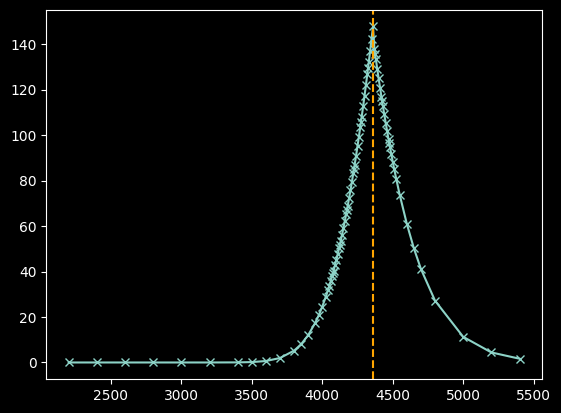

T: 2022-03-23


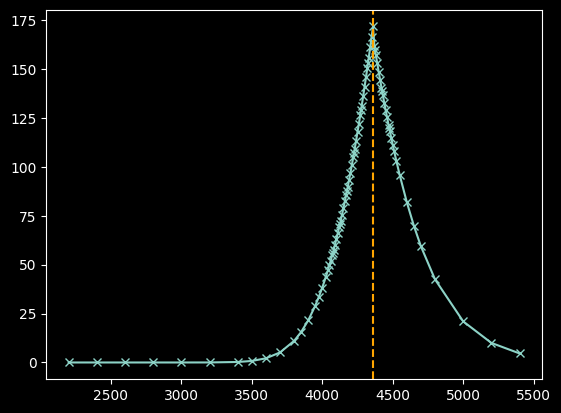

T: 2022-03-25


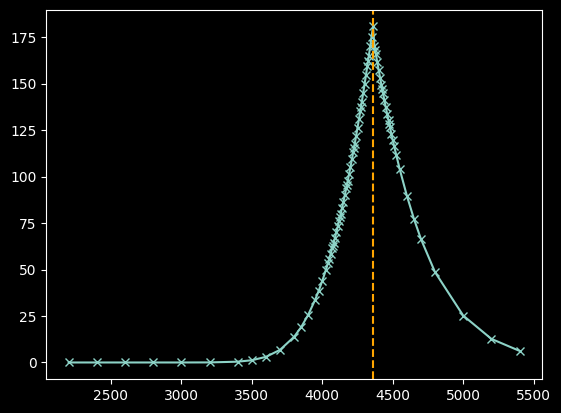

T: 2022-03-30


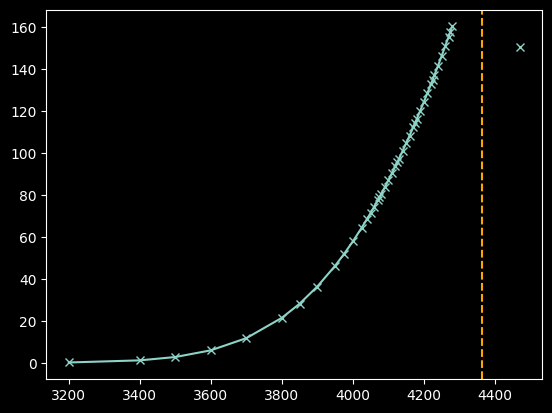

T: 2022-03-31


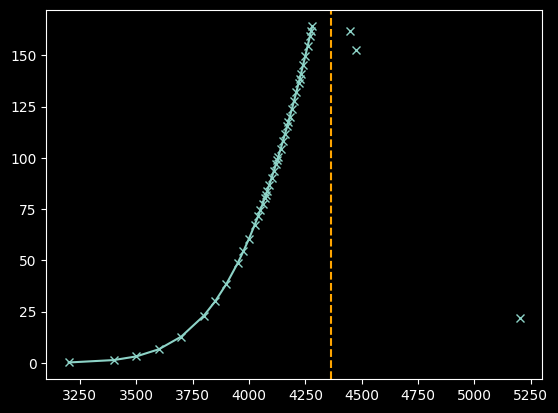

T: 2022-04-01


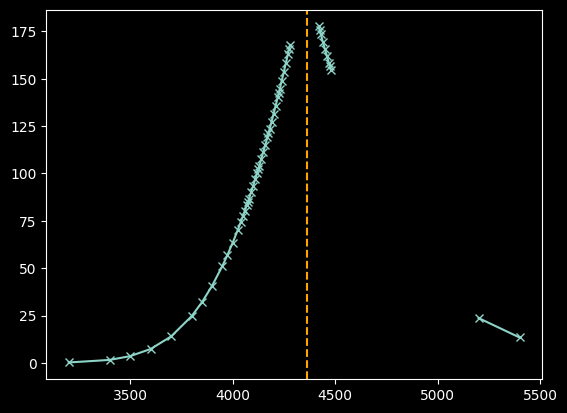

T: 2022-04-08


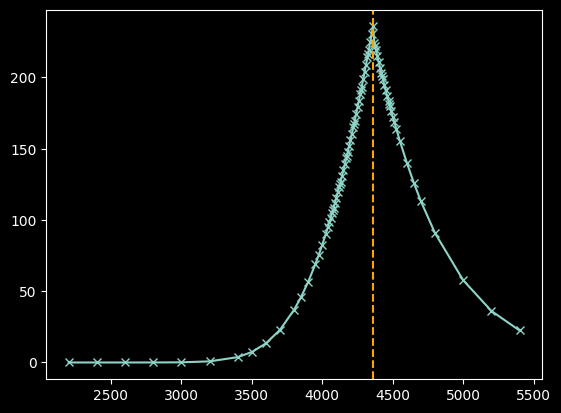

T: 2022-04-14


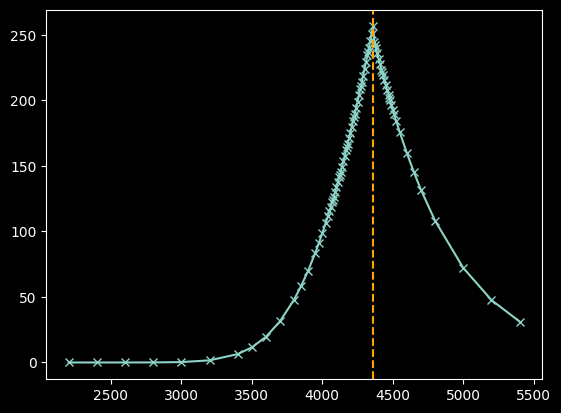

T: 2022-04-22


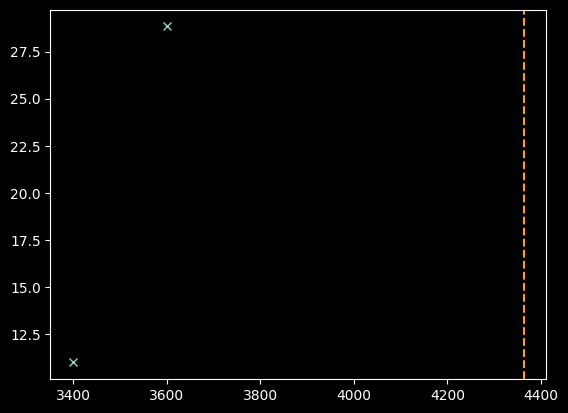

T: 2022-04-29


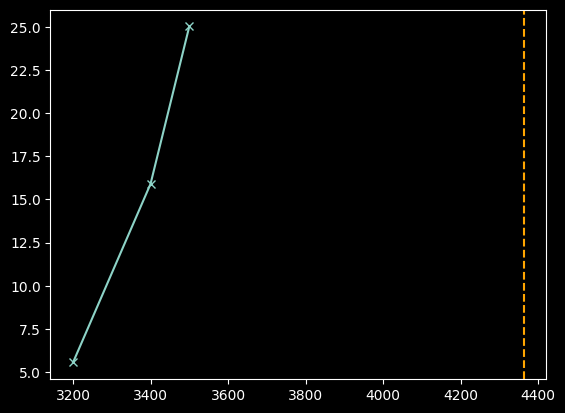

T: 2022-05-20


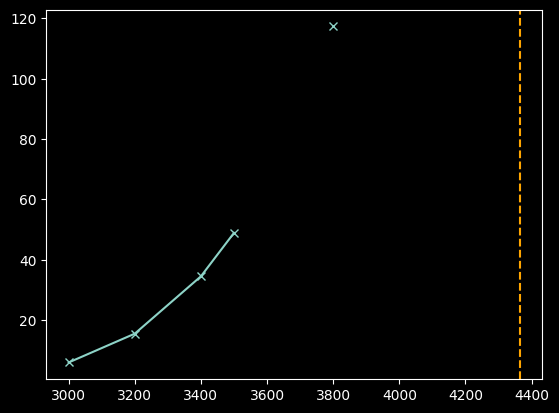

T: 2022-05-31


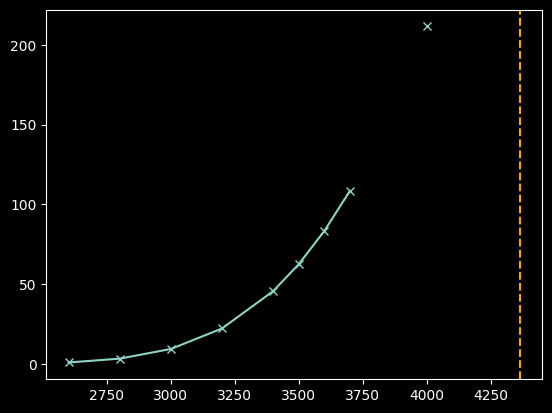

T: 2022-06-17


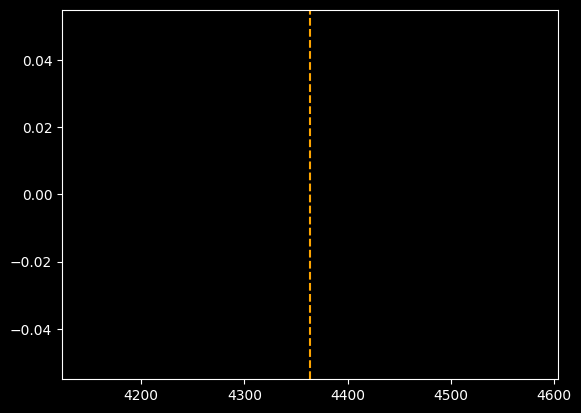

T: 2022-06-30


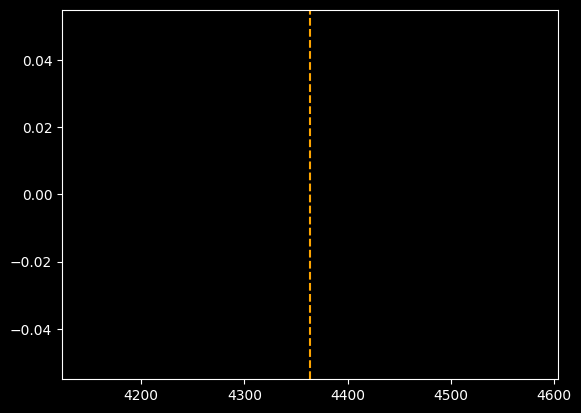

T: 2022-07-15


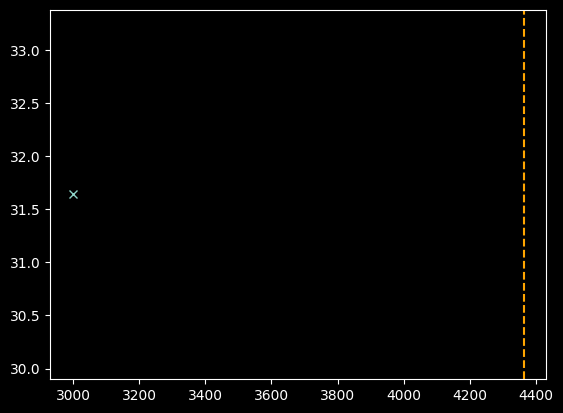

T: 2022-07-29


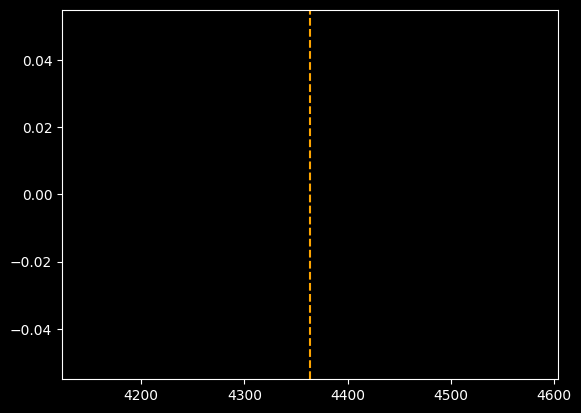

T: 2022-08-31


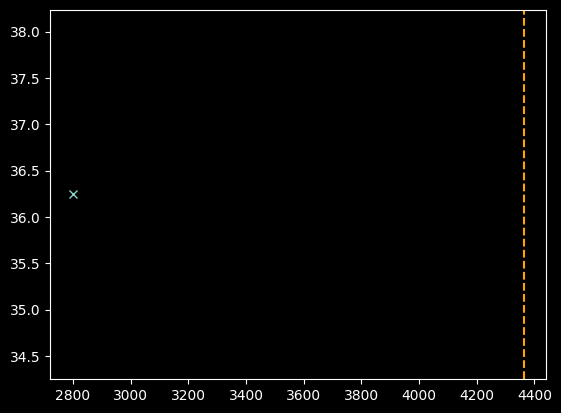

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from pandas import DataFrame
from typing import cast
import matplotlib.pyplot as plt

from stochastic_volatility_models.src.core.underlying import Underlying
from stochastic_volatility_models.src.core.volatility_surface import VolatilitySurface
from stochastic_volatility_models.src.core.pricing_models import PricingModel
from stochastic_volatility_models.src.utils.options.strikes import find_closest_strikes
from stochastic_volatility_models.src.utils.options.expiry import time_to_expiry
from stochastic_volatility_models.visualisations.volatility_surface import plot_volatility_surface


volatility_surface = spx_vs
surface = volatility_surface.surface_quantities(
	time=time,
	quantity_method="model_price",
	price_types=["Mid"],
	out_the_money=True,
	model=model,
)[0]
for i, expiry in enumerate(volatility_surface.expiries):
	print(f"T: {expiry}")
	t2x = time_to_expiry(time, volatility_surface.expiries)
	indices = find_closest_strikes(
		strikes=volatility_surface.strikes,
		spot=volatility_surface.underlying.price(time=time),
	)
	x = np.linspace(indices.min(), indices.max(), 100)
	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.axvline(spot, color="orange", linestyle="dashed")
	plt.show()

In [14]:
# parameters = model.fit(
# 	index_volatility_surface=spx_vs,
# 	volatility_index_volatility_surface=vix_vs,
# 	time=time,
# 	pricing_model=PricingModel(),
# )
# print(parameters)
